# Peak finding for ACOM - Ti550 

This notebook demonstates automated crystal orientation mapping (ACOM) mapping of a real 4D-STEM dataset of a Ti alpha beta area.

## Data
This is a real 4D-STEM dataset from a Ti550 sample from Mr Enrique Frutos-Myro at University of Glasgow
You should then set the `filepath` variable in the cell below.

## Acknowlegements

This notebook was made Ian MacLaren on the basis of example notebooks by Colin Ophus, Steven Zeltmann, and Benjamin Savitzky. Contact ian.maclaren@glasgow.ac.uk and clophus@lbl.gov with any questions.

### Versioning

Last updated on 2023-01-24 with py4DSTEM v.0.13.10.

In [1]:
import numpy as np
import py4DSTEM
#from py4DSTEM.process.virtualimage import get_virtual_image
from py4DSTEM.io.datastructure.py4dstem.virtualimage import VirtualImage
import h5py
import matplotlib.pyplot as plt
print(py4DSTEM.__version__)
import pickle
# extra import for doing rotations
import scipy.ndimage as ndi
# For counting performance
import time

0.13.10


In [2]:
py4DSTEM.check_config()

2023-03-03 07:48:46.903052: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
/local/environments/py4dstem_latest/py4dstem_latest-venv/lib64/python3.8/site-packages/pymatgen/analysis/phase_diagram.py:26: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Checking Module Dependencies
 All Dependencies for Base are Installed 
 All Dependencies for Ipyparallel are Installed 
 All Dependencies for Cuda are Installed 
 Not All Dependencies for Acom are Installed
 Not All Dependencies for Aiml are Installed
 Not All Dependencies for Aiml-cuda are Installed
 All Dependencies for Numba are Installed 


In [3]:
#import crystals
Ti_alpha = py4DSTEM.process.diffraction.Crystal.from_CIF(
    '/local/scratch/EnriqueTitanium/Ti_alpha.cif'
)
Ti_beta = py4DSTEM.process.diffraction.Crystal.from_CIF(
    '/local/scratch/EnriqueTitanium/Ti_beta.cif'
)

/local/environments/py4dstem_latest/py4dstem_latest-venv/lib64/python3.8/site-packages/pymatgen/io/cif.py:1153: UserWarning: Issues encountered while parsing CIF: Some fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))


In [4]:
# Note - change the file path to your own local path
filepath = '/local/scratch/EnriqueTitanium/2019_10_04_Ti_550/Scan5/'
file = 'Ti550 005.hdf5'

In [5]:
# Load 4DSTEM dataset
f = h5py.File(filepath+file, 'r')
ds = f['fpd_expt/fpd_data/data']

In [6]:
#Find scan stepsize in data
step = f['fpd_expt/fpd_data/dim1'][1] - f['fpd_expt/fpd_data/dim1'][0]
step

3.0

# Load the data

### What this data is

The data here is meant to represent everything needed to perform orientation mapping.

#### `dataset` (Ti)

This is a 4D-STEM scan of a Ti550 sample with both beta and alpha titanium.

In [7]:
# Load the datacube
dataset = py4DSTEM.io.datastructure.DataCube(data = ds[()])

In [8]:
# Display some information for the loaded file
dataset

DataCube( A 4-dimensional array of shape (100, 191, 256, 256) called 'datacube',
          with dimensions:

          Rx = [0,1,...] pixels
          Ry = [0,1,...] pixels
          Qx = [0,1,...] pixels
          Qy = [0,1,...] pixels
)

In [9]:
# Calculate these images:
#     -max diffraction pattern from dataset
#     -mean diffraction pattern from dataset
dataset.get_dp_max();
dataset.get_dp_mean();

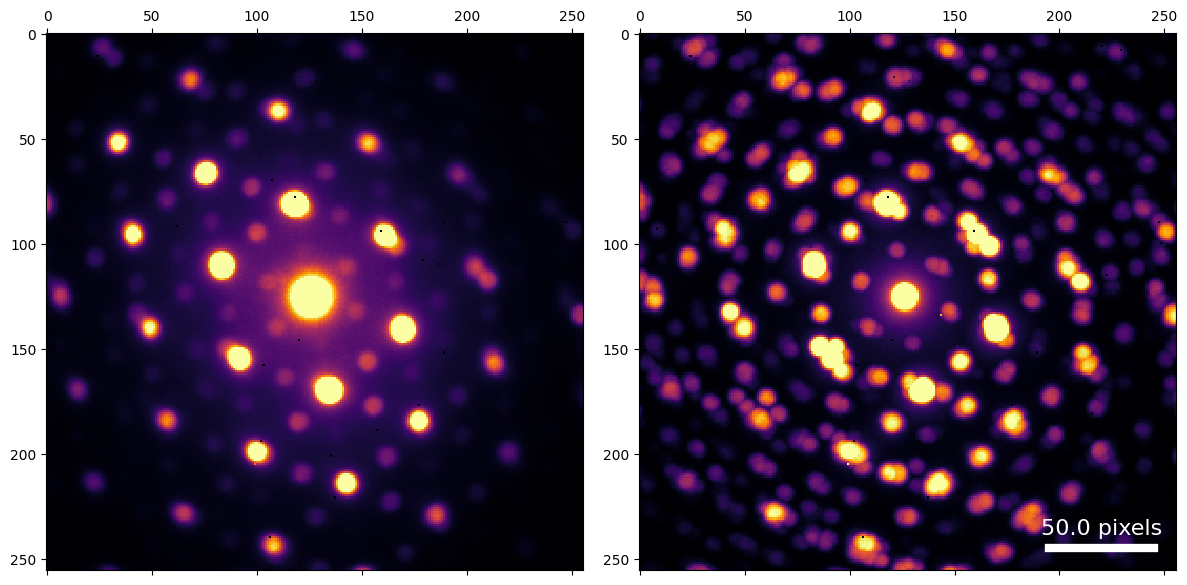

In [10]:
py4DSTEM.visualize.show_image_grid(
    lambda i:[
#         dataset.tree['dp_mean'], 
        dataset.tree['dp_mean'].data, 
        dataset.tree['dp_max'], 
    ][i],
    H=1,
    W=2,
    cmap='inferno',
)

# Visualize the Data

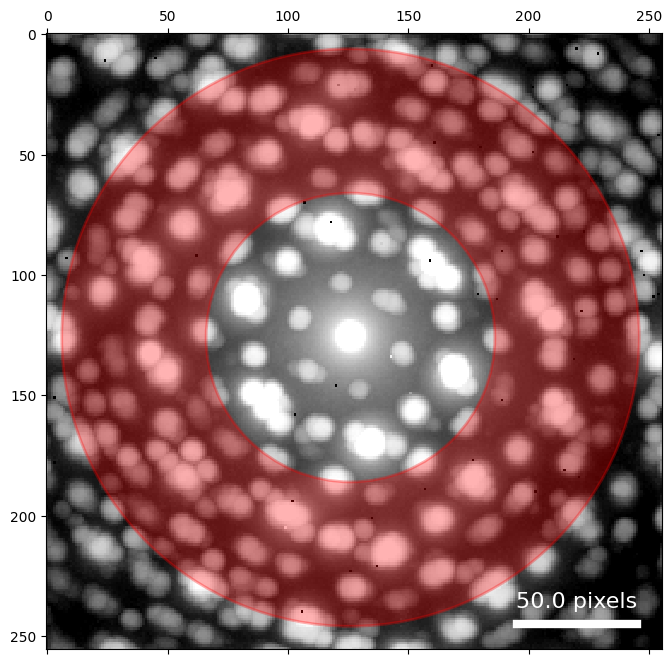

100%|██████████| 19100/19100 [00:01<00:00, 13542.97it/s]


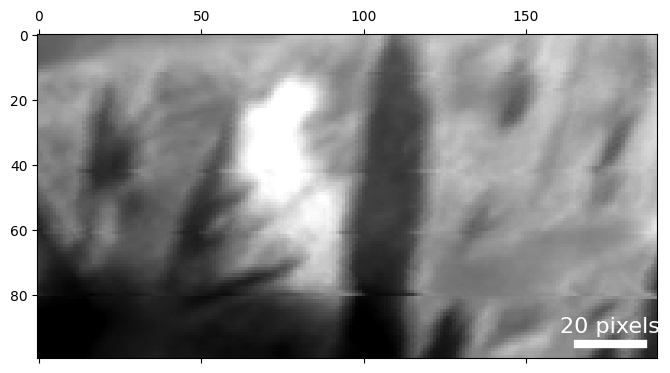

In [11]:
# Create an annular dark field (ADF) virtual detector using user-chosen values:
center = (126,126)
radii = (60,120)

# Plot the ADF detector
py4DSTEM.visualize.show(
    dataset.tree['dp_max'], 
    scaling='log',
    annulus = {
      'center':center,
      'radii':radii,
      'alpha':0.3,
      'fill':True
    }
)

# Calculate the ADF imagedataset.VirtualImage(
dataset.get_virtual_image(mode = 'annulus', 
                          geometry = (center,radii),
                          name = 'dark_field')
# Plot the ADF image
py4DSTEM.visualize.show(dataset.tree['dark_field'])

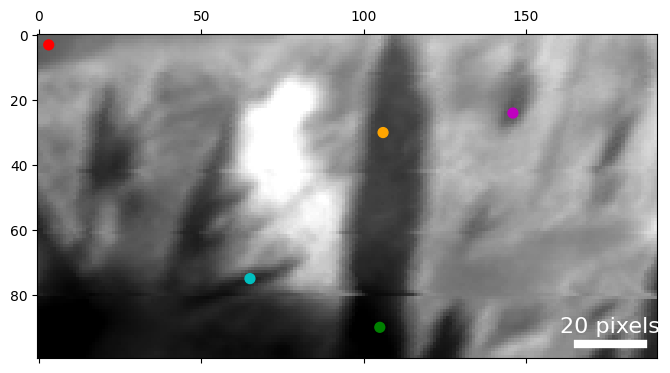

In [20]:
# Choose some diffraction patterns to use for hyperparameter tuning

rys = 3,146,65,105,106
rxs = 3,24,75,90,30,
colors=['r','m','c','g','orange']

py4DSTEM.visualize.show_points(
    dataset.tree['dark_field'],
    x=rxs,
    y=rys,
    pointcolor=colors,
    figsize=(8,8)
)

# Prepare the probe template

Here we
- measure the center position and radius of the probe image
- generate a probe kernel for the template-matching disk detection step

Creating a good probe kernel is *essential* for the disk detection algorithm to work well - tuning the parameters you pass to `find_Bragg_disks` won't do you a lick of good if your kernel is no good.  More discussion of what makes a good probe template, and how to generate one, coming soon to a demo notebook near you.

100%|██████████| 199/199 [00:02<00:00, 77.31it/s]


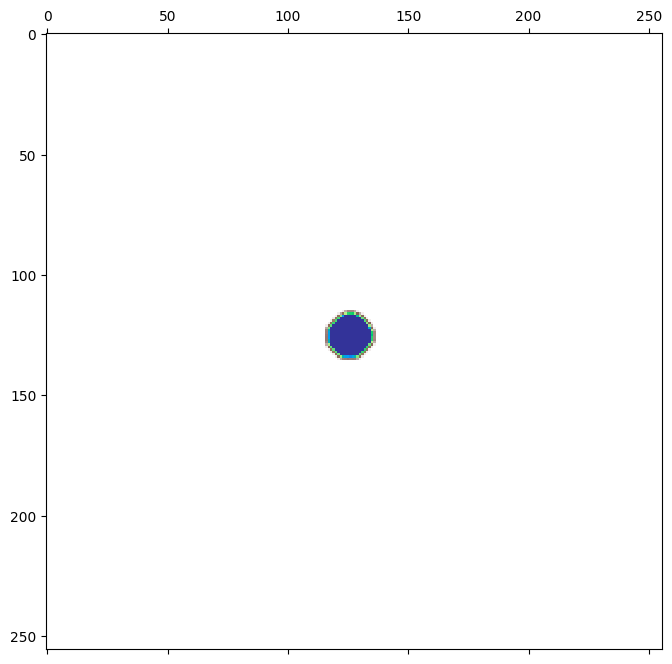

In [13]:
#Adjust area selected and threshold to find a suitable
#probe sample without surrounding Bragg peaks
probenew = py4DSTEM.process.probe.get_probe_from_4Dscan_ROI_lims(
    dataset,
    (60,70,0,20),
    mask_threshold=0.50,
    mask_expansion=4,
    mask_opening=2,
    verbose=False,
    align=True,
    )
py4DSTEM.visualize.show(
    probenew,
    figsize=(8,8),
    cmap='terrain_r',
    intensity_range='absolute',
    vmin=0,
    vmax=1000
)

Estimated probe radius = 6.66 pixels
125.34489069470384 125.83865803701092


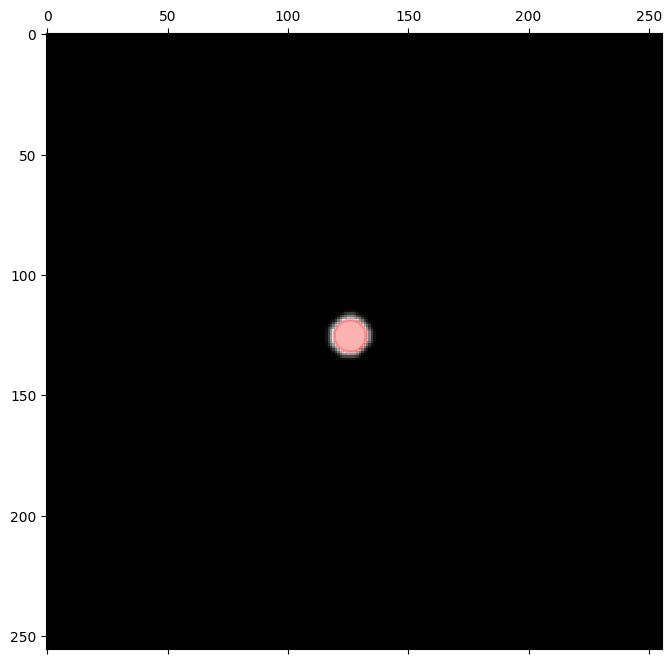

In [14]:
# Estimate the semiangle (radius) of the probe, and the center coordinates.
# Note that we need to lower the thresholds to make the get_probe_size() function work with a bullseye probe.

probe_semiangle, probe_qx0, probe_qy0 = py4DSTEM.process.calibration.get_probe_size(
    probenew,
    thresh_lower = 0.1,
    thresh_upper = 1,
)

# plot the mean diffraction pattern, with the estimated probe radius overlaid as a circle
fig, ax = py4DSTEM.visualize.show_circles(
    probenew, 
    (probe_qx0, probe_qy0), 
    probe_semiangle,
    intensity_range='absolute',
    vmin=0,
    vmax=3000, 
    returnfig=True,
)

# uncomment these lines to zoom in
#ax.set_xlim([100, 150])
#ax.set_ylim([100, 150])

# Print the estimate probe radius
print('Estimated probe radius =', '%.2f' % probe_semiangle, 'pixels')
print(probe_qx0, probe_qy0)

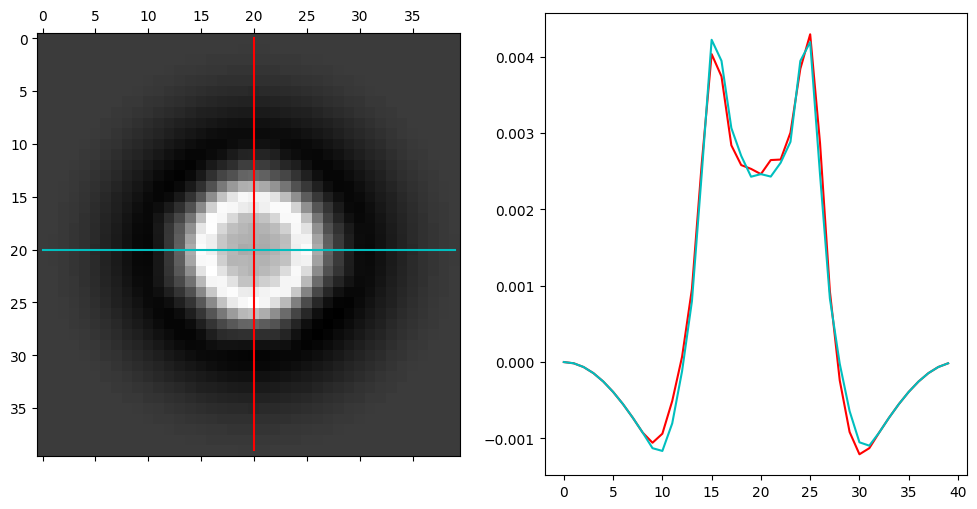

In [15]:
# Construct a probe template to use as a kernel for correlation disk detection

probe_kernel = py4DSTEM.process.probe.get_probe_kernel_edge_sigmoid(
    probenew,
    (probe_semiangle * 0.0, probe_semiangle * 3.0),
#     bilinear=True,
)

# Plot the probe kernel
py4DSTEM.visualize.show_kernel(
    probe_kernel, 
    R=20, 
    L=20, 
    W=1)

## Disk detection

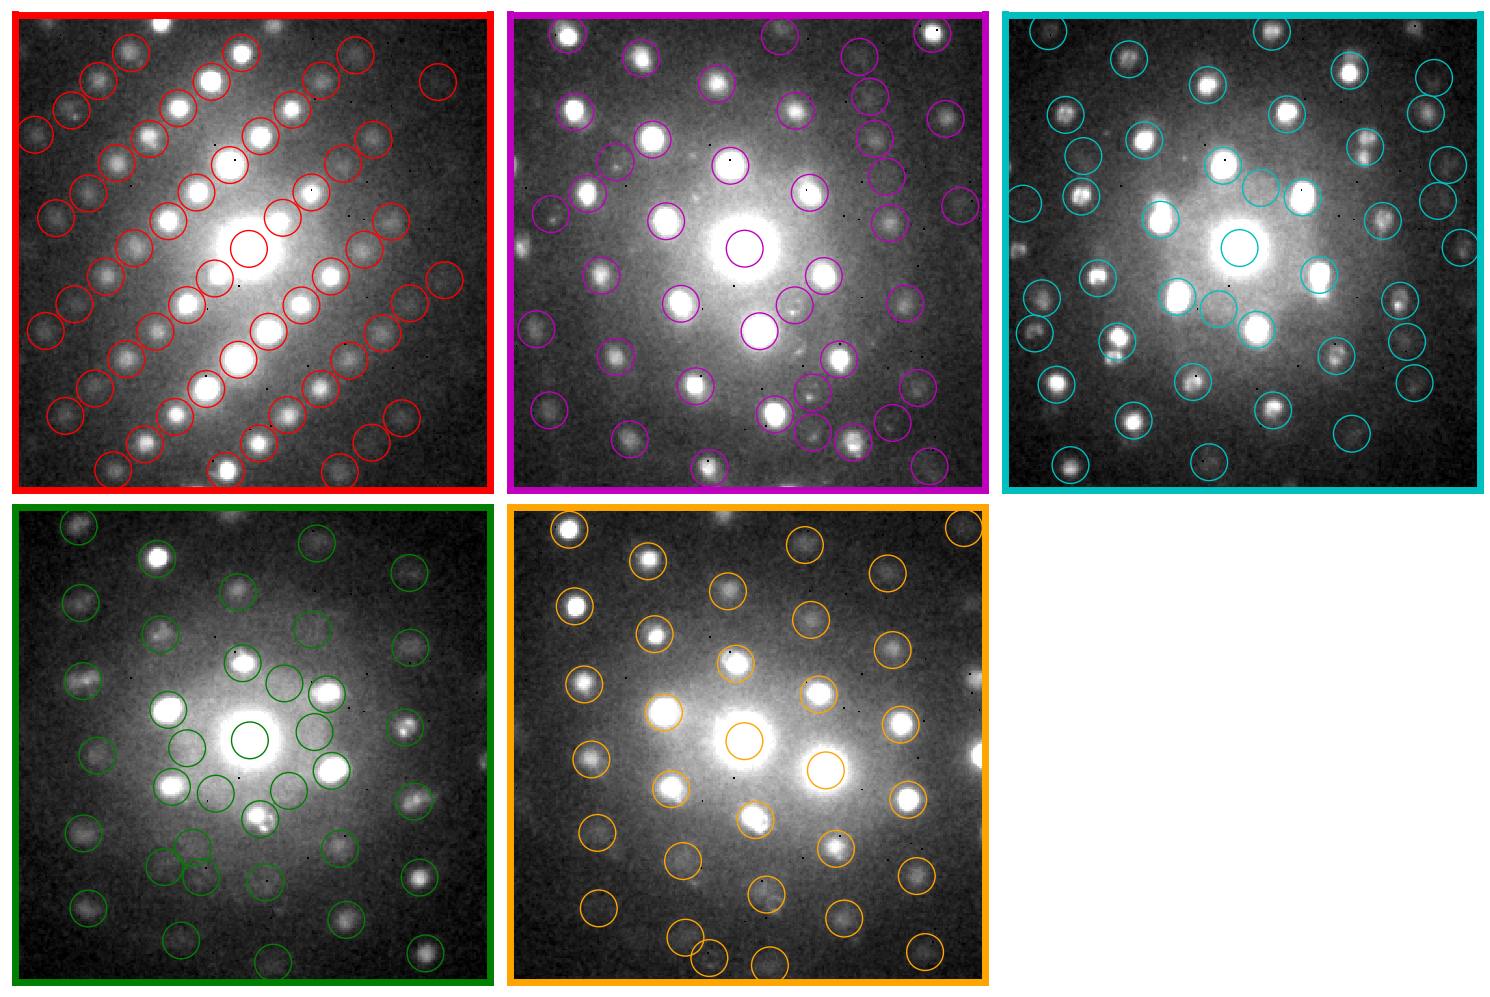

In [22]:
# Test hyperparameters on a few probe positions
# Visualize the diffraction patterns and the located disk positions

# Hyperparameters
detect_params = {
    'corrPower': 1.0,
    'sigma': 0,
    'edgeBoundary': 8,
    'minRelativeIntensity': 0,
    'minAbsoluteIntensity': 3,
    'minPeakSpacing': 12,
    'subpixel' : 'poly',
    'upsample_factor': 8,
    'maxNumPeaks': 1000,
    'CUDA': True,
    'CUDA_batched': True,
}

disks_selected = dataset.find_Bragg_disks(
    data = (rxs, rys),
    template = probe_kernel,
    **detect_params,
)

py4DSTEM.visualize.show_image_grid(
    get_ar = lambda i:dataset.data[rxs[i],rys[i],:,:],
    H=2, 
    W=3,
    axsize=(5,5),
    intensity_range='absolute',
    vmin=5,
    vmax=500,
    scaling='power',
    power=0.5,
    get_bordercolor = lambda i:colors[i],
    get_x = lambda i: disks_selected[i].data['qx'],
    get_y = lambda i: disks_selected[i].data['qy'],
    get_pointcolors = lambda i: colors[i],
    open_circles = True,
    scale = 700,
)

In [17]:
# Find all Bragg peaks
# Note that here we have used "poly" disk detection, which is much faster, but less accurate.
# We do not need extremely precise peak locations to perform an ACOM analysis.

start = time.perf_counter()
bragg_peaks = dataset.find_Bragg_disks(
    template = probe_kernel,
    **detect_params,
)
elapsed_CUDA_on = time.perf_counter() - start

Using 9 batches of 2255 patterns each...


Finding Bragg disks in batches: 100%|██████████| 9/9 [00:43<00:00,  4.79s/batch]


Analyzed 19100 diffraction patterns in 0.0h 0.0m 43.10s
(avg. speed 443.1460 patterns per second)


## Save raw peak positions

In [23]:
# minor hack of the filename for saving
filename_output_braggpeaks = file.replace('.hdf5','_bp.h5')

In [19]:
# Save Bragg disk positions
py4DSTEM.save(
    filepath+filename_output_braggpeaks,
    bragg_peaks,
    mode='o',
)

100%|██████████| 19100/19100 [00:03<00:00, 5316.47it/s]


In [20]:
py4DSTEM.io.print_h5_tree(filepath+filename_output_braggpeaks)

/
|--4DSTEM
	|--braggvectors
		|--_v_uncal
		|--calibration




In [21]:
# Check calibration - should just be 1 pixel
bragg_peaks.calibration

Calibration( A Metadata instance called 'calibration', containing the following fields:

             Q_pixel_size:    1
             R_pixel_size:    1
             Q_pixel_units:   pixels
             R_pixel_units:   pixels
)

In [24]:
# Reload Bragg peaks if needed
bragg_peaks = py4DSTEM.read(
    filepath+filename_output_braggpeaks, 
    root = '/4DSTEM/braggvectors'
)

Reading PointListArray: 100%|██████████| 19100/19100 [00:03<00:00, 4918.89PointList/s]


## Bragg peak calibration

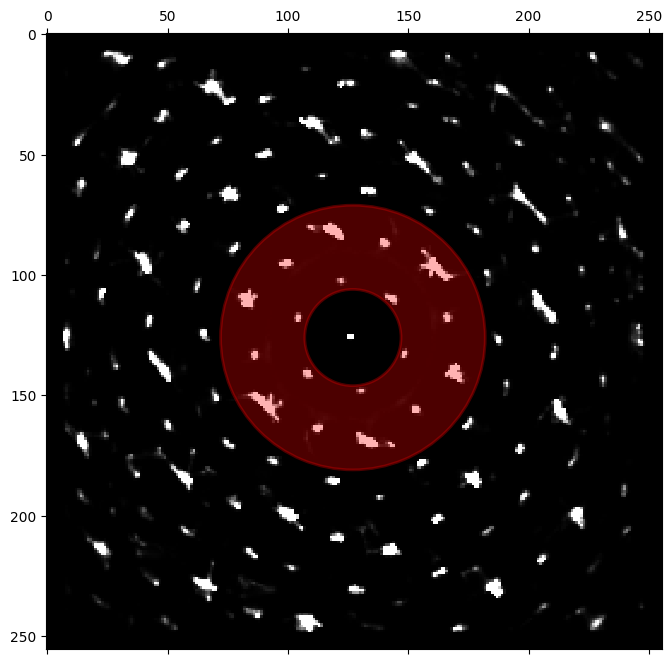

In [25]:
# Guess the center coordinate, specify the radial range for fitting peak pairs
center_guess = (126,127)
radial_range = (20,55)

# Show the ADF detector, overlaid over a new BVM
bragg_vector_map = bragg_peaks.get_bvm(mode='raw')
py4DSTEM.show(
    bragg_vector_map, 
    intensity_range='absolute',
    vmin=0,
    vmax=10000,
    annulus = {
      'center':center_guess,
      'radii' : radial_range,
      'alpha':0.3,
      'fill':True
    }
)

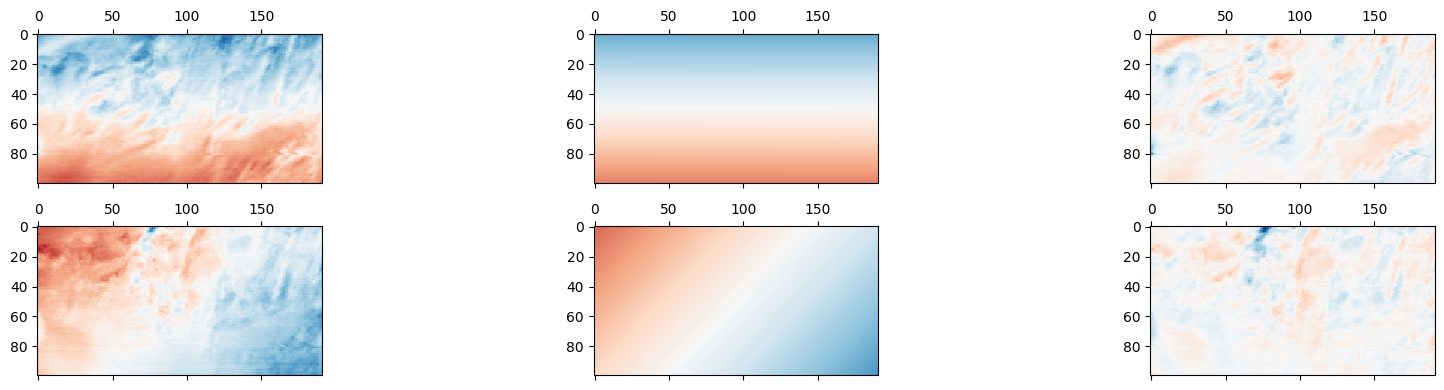

In [26]:
# Compute the origin position for all probe positions.
# This algorithm works by searching for peak pairs (Friedel symmetry) and finding the mean position of these pairs.

qxy_origins = bragg_peaks.measure_origin(
    mode = 'no_beamstop',
    center_guess = center_guess,
    radii = radial_range,
)

# Fit a plane to the origins
qx0_fit,qy0_fit,qx0_residuals,qy0_residuals = bragg_peaks.fit_origin()

In [27]:
# apply the calibration
bragg_peaks.calibration.set_origin((qx0_fit, qy0_fit))
bragg_peaks.calibrate()

# Calculate BVM from centered data
bragg_vector_map_centered = bragg_peaks.get_bvm()
bragg_vector_map_cali = bragg_vector_map_centered

# Pixel size calibration

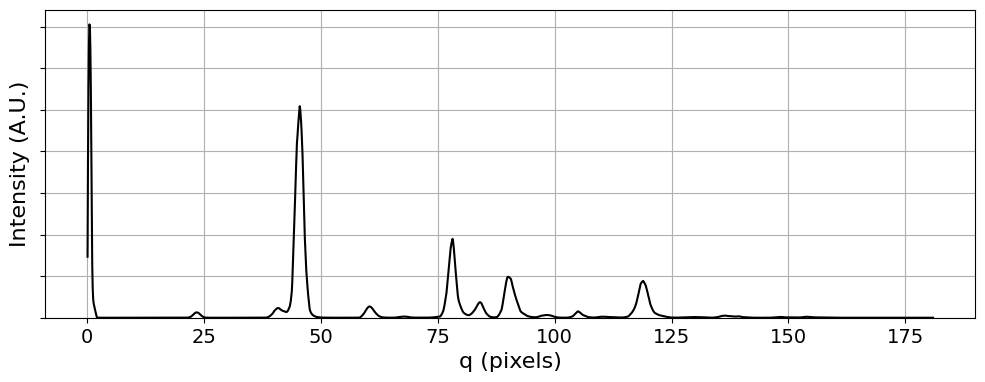

In [28]:
# Calculate and plot the radial integral 
q, intensity_radial = py4DSTEM.process.utils.radial_integral(
    bragg_vector_map_cali,
)

py4DSTEM.visualize.show_qprofile(
    q = q,
    intensity = intensity_radial * q,
)

(0.0, 90000000.0)

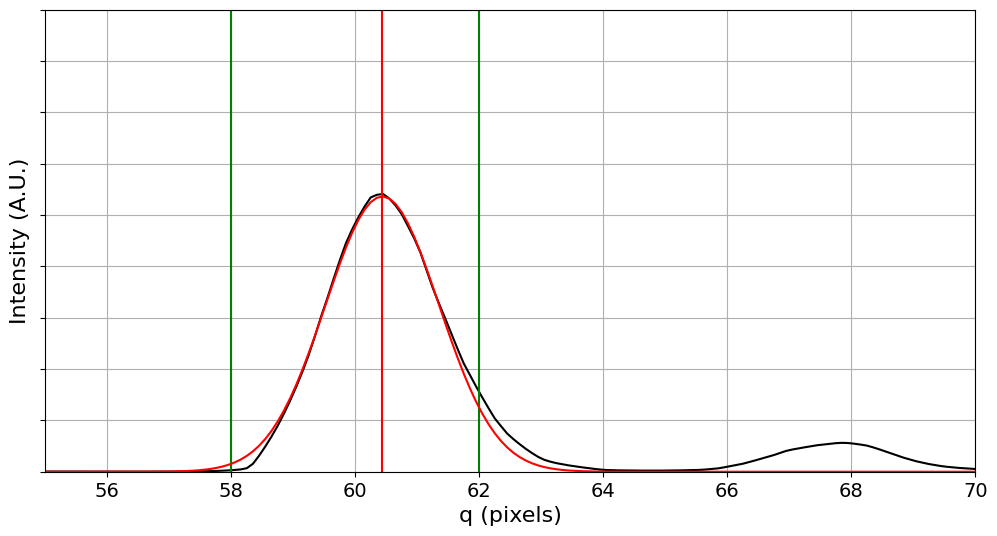

In [29]:
# Fit a gaussian to find a peak location

q_peak_min, q_peak_max = 58, 62

A,mu,sigma = py4DSTEM.process.fit.fit_1D_gaussian(
    q,
    intensity_radial,
    q_peak_min,
    q_peak_max)

fig,ax = py4DSTEM.visualize.show_qprofile(
    q=q,
    intensity=intensity_radial*q,
    returnfig=True,
    figsize=(12,6))

ax.vlines((q_peak_min,q_peak_max),0,ax.get_ylim()[1],color='g')
ax.vlines(mu,0,ax.get_ylim()[1],color='r')
ax.plot(q,py4DSTEM.process.fit.gaussian(q,A,mu,sigma)*60,color='r')
ax.set_xlim([55, 70])
ax.set_ylim([0, 9e7])

In [30]:
Ti_alpha.cell

array([  2.9514,   2.9514,   4.6814,  90.    ,  90.    , 120.    ])

In [31]:
def d_hkil(hkil, a, c):
    # hkil comes as list
    Lam = np.sqrt(2/3)*c/a
    into4d = hkil*np.array([1,1,1,1/Lam])
    d = np.sqrt(3/2)*a/np.linalg.norm(into4d)
    return d

In [32]:
def d_list(Miller_array, a, c):
    l = Miller_array.shape[0]
    d = np.zeros(shape=l)
    for i in range(l):
        d[i] = d_hkil(Miller_array[i], a, c)
    return d

In [33]:
# Work out array of possible hkl values for alpha Ti:
# all odd, or all even and h+k+l = 4n
Miller_Ti = np.array([
    [0,0,0,1],
    [1,-1,0,0],
    [0,0,0,2],
    [1,-1,0,1],
    [1,-1,0,2],
    [0,0,0,3],
    [2,-1,-1,0],
    [2,-1,-1,1],
    [1,-1,0,3],
    [2,-2,0,0],
    [2,-2,0,1],
    [2,-1,-1,2],
    [0,0,0,4],
    [2,-2,0,2],
    [2,-1,-1,3],
    [1,-1,0,4],
    [2,-2,0,3],
    [3,-2,-1,0],
    [3,-2,-1,1],
    [0,0,0,5],
    [2,-1,-1,4],
    [3,-2,-1,2],
    [0,0,0,1],
    [1,-1,0,5],
    [3,-2,-1,3],
    [2,-1,-1,5],
    [0,0,0,6],
    [2,-2,0,5],
    [1,-1,0,6],
    [4,-2,-2,0],
    [4,-3,-1,0],
    ]
)
c_Ti = Ti_alpha.cell[2]
a_Ti = Ti_alpha.cell[0]
d_Ti = d_list(Miller_Ti, a_Ti, c_Ti)
d_Ti

array([4.6814    , 2.55598738, 2.3407    , 2.24338689, 1.72622634,
       1.56046667, 1.4757    , 1.40742939, 1.33187145, 1.27799369,
       1.23287859, 1.24832247, 1.17035   , 1.12169345, 1.07219251,
       1.06410437, 0.98872481, 0.96607242, 0.94613633, 0.93628   ,
       0.91697642, 0.89300285, 4.6814    , 0.87915284, 0.8214014 ,
       0.79058253, 0.78023333, 0.75527877, 0.74623959, 0.73785   ,
       0.70890335])

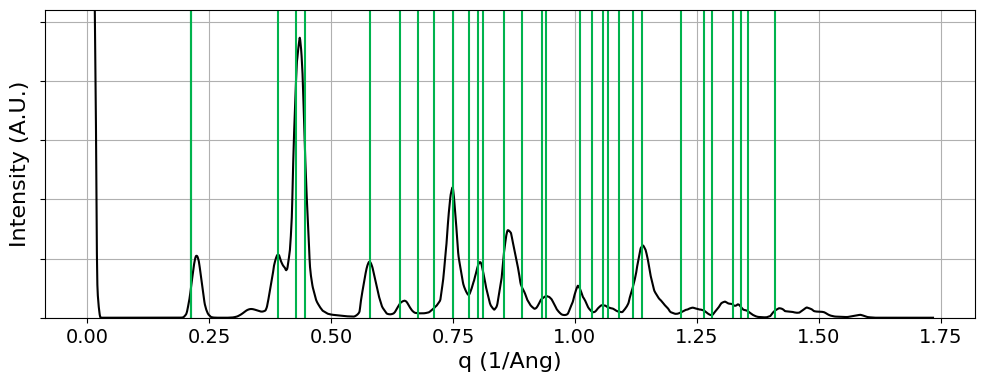

In [34]:
# Get pixel calibration
# One peak with a known spacing must be manually identified and entered
# This is the Ti alpha 0002 peak

spacings_inv_Ang = 1./d_Ti
inv_Ang_per_pixel = 1./(d_Ti[4] * mu)
fig,ax = py4DSTEM.visualize.show_qprofile(
    q=q*inv_Ang_per_pixel,
    intensity=intensity_radial**0.5,
    ymax=(intensity_radial[20:]**0.5).max()*1.1,xlabel='q (1/Ang)',returnfig=True)
ax.vlines(spacings_inv_Ang,0,ax.get_ylim()[1],color=(0,0.7,0.3))

In [35]:
# Apply pixel size calibration
bragg_peaks.calibration.set_Q_pixel_size(inv_Ang_per_pixel)
bragg_peaks.calibration.set_Q_pixel_units('A^-1')
bragg_peaks.calibration.set_R_pixel_size(step)
bragg_peaks.calibration.set_R_pixel_units('nm')
bragg_peaks.calibrate()

# Rotation Calibration from double image

In [36]:
rotations_frame = pickle.load( open( "/local/scratch/EnriqueTitanium/rotations_frame.p", "rb" ) )
rotations_frame

Scan_rotation  Diff_to_image
2018_08_15_001            0.00000       0.087266
2018_08_15_002            0.00000       0.087266
2018_08_15_003            0.00000       0.087266
2018_08_15_004            0.15708       6.213372
2018_08_15_005            0.15708       6.213372
2018_10_02_EFM001        -4.76230       4.849566
2019_02_08_002            1.43120       4.939252
2019_03_19_ROI1           0.00000       0.087266
2019_03_19_ROI2           0.00000       0.087266
2019_03_19_ROI3           6.10870       0.261752
2019_10_04_Area1          5.77700       0.593452
2019_10_04_Area2          5.77700       0.593452
2019_10_04_Area3          5.77700       0.593452
2019_10_04_Area4          5.77700       0.593452
2019_10_04_Area5          5.77700       0.593452
2019_10_11_Scan1          1.22170       5.148752
2019_10_11_Scan2          1.22170       5.148752
2019_10_11_Scan3          1.22170       5.148752
2019_10_11_Scan4          1.22170       5.148752
2020_02_17_EFM024         1.57080       4.799652
2020_02_17_EFM025         1.39630       4.974152
2020_02_17_EFM026         1.39630       4.974152
2020_02_17_EFM027         1.22170       5.148752
2020_02_17_EFM028         1.22170       5.148752
2020_02_17_EFM029         1.22170       5.148752
2020_02_17_EFM030         1.22170       5.148752
2020_02_17_EFM031         0.00000       0.087266
2020_02_17_EFM032         0.00000       0.087266
2020_02_17_EFM033         1.22170       5.148752
2020_02_17_EFM034         1.22170       5.148752
2020_02_17_EFM035         1.22170       5.148752
2022_08_12_Scan001        0.78540       5.585052
2022_08_12_Scan002        0.78540       5.585052
2022_08_12_Scan003        0.78540       5.585052
2022_08_12_Scan004        0.78540       5.585052
2022_08_12_Scan005        1.57080       4.799652
2022_08_12_Scan006        0.78540       5.585052
2022_08_12_Scan007        0.78540       5.585052
2022_08_12_Scan009        1.22170       5.148752

In [37]:
calib_rot = rotations_frame['Diff_to_image']['2019_10_04_Area5']
angle = np.degrees(calib_rot)
angle

34.00228175292341

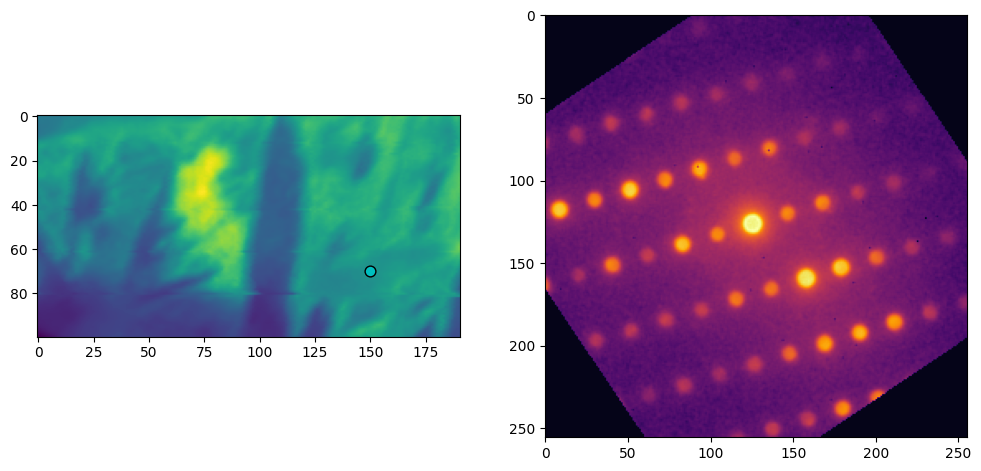

In [38]:
# take known diffraction pattern (close to [001]) and rotate to fit
#y,x = 30,160
y, x = 70,150
#y, x = 150, 50
dpat=dataset.data[y,x,:,:]
#sh1 = int((dpat.shape[0] - dataset.tree['dark_field'].data.shape[0])/2)
#sh2 = int((dpat.shape[1] - dataset.tree['dark_field'].data.shape[1])/2)
dpat_rot = (ndi.rotate(dpat,angle, reshape=False, cval=1.))
#dpat_rot = dpat_rot-dpat_rot.min()

# show a double image, change angle above, if needed.  Lining up spots with cuts.
fig, axs = plt.subplots(1,2, figsize=(12,8))

axs[0].scatter(x,y, fc='c', ec='k', s=60)
axs[0].imshow(dataset.tree['dark_field'].data)
#alp = np.power(dpat_rot/dpat_rot.max(),0.2)
axs[1].imshow(dpat_rot**0.2, cmap='inferno')

In [39]:
#Apply the calibrated rotation to the Bragg peaks
#Needs angle in radians
flip=False
bragg_peaks.calibration.set_QR_rotflip((calib_rot, flip))
bragg_peaks.calibrate()
# Recompute the bvm
bragg_vector_map_cali = bragg_peaks.get_bvm()

In [40]:
file_name_braggdisks_cali = file.replace('.hdf5','_braggdisks_cali.h5')

In [32]:
# Save calibrated Bragg peaks
py4DSTEM.save(
    filepath+file_name_braggdisks_cali,
    bragg_peaks,
    mode='o',
)

100%|██████████| 19100/19100 [00:03<00:00, 5258.69it/s]


# ACOM

In [33]:
# Reload Bragg peaks if needed
py4DSTEM.io.print_h5_tree(filepath+file_name_braggdisks_cali)

/
|--4DSTEM
	|--braggvectors
		|--_v_cal
		|--_v_uncal
		|--calibration




In [32]:
bragg_peaks = py4DSTEM.read(
    filepath+file_name_braggdisks_cali, 
    root = '/4DSTEM/braggvectors'
)
bragg_peaks

Reading PointListArray: 100%|██████████| 19100/19100 [00:03<00:00, 5380.80PointList/s]


BraggVectors( A (100, 191)-shaped array of lists of bragg vectors )

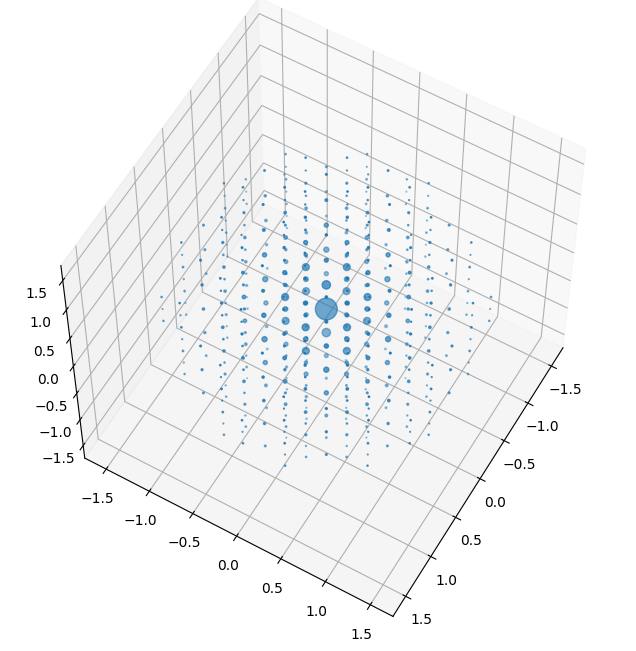

In [48]:
# Calculate and plot titanium alpha structure factors
k_max = 1.6
tol_structure_factor = 0.01

q_SF, int_SF = Ti_alpha.calculate_structure_factors(
    k_max, 
    tol_structure_factor=tol_structure_factor,
    return_intensities=True)
Ti_alpha.plot_structure_factors(zone_axis_lattice=[1,1,1])

### Add beta details

In [49]:
Ti_beta.cell

array([ 3.2322,  3.2322,  3.2322, 90.    , 90.    , 90.    ])

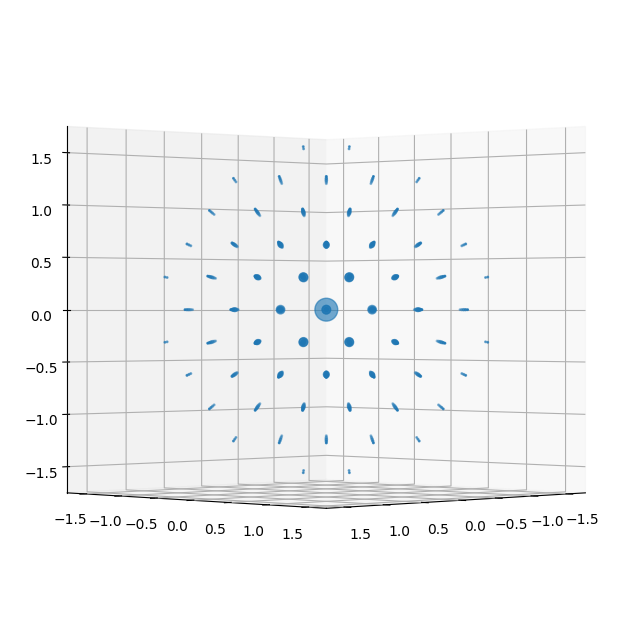

In [50]:
# Calculate and plot titanium beta structure factors
q_SFb, int_SFb = Ti_beta.calculate_structure_factors(
    k_max, 
    tol_structure_factor=tol_structure_factor,
    return_intensities=True)
Ti_beta.plot_structure_factors(zone_axis_lattice=[1,1,0])

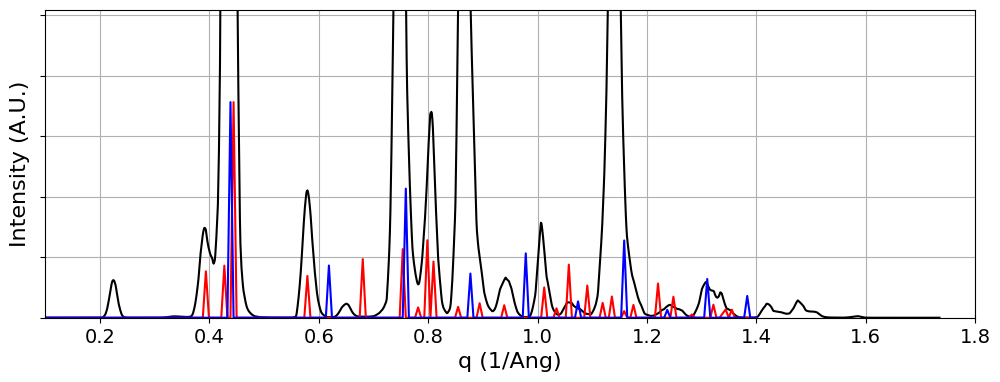

In [47]:
# overlay the structure factors onto the experimental data
ymax = (intensity_radial*q)[20:].max()

q_SF = np.linspace(0,k_max,250)
I_SF = np.zeros_like(q_SF)
for i in range(Ti_alpha.g_vec_leng.shape[0]):
    idx = np.argmin(np.abs(q_SF-Ti_alpha.g_vec_leng[i]))
    I_SF[idx] += Ti_alpha.struct_factors_int[i]
I_SF /= np.max(I_SF)

q_SFb = np.linspace(0,k_max,250)
I_SFb = np.zeros_like(q_SF)
for i in range(Ti_beta.g_vec_leng.shape[0]):
    idx = np.argmin(np.abs(q_SFb-Ti_beta.g_vec_leng[i]))
    I_SFb[idx] += Ti_beta.struct_factors_int[i]
I_SFb /= np.max(I_SFb)

fig,ax = py4DSTEM.visualize.show_qprofile(
    q=q*inv_Ang_per_pixel,
    intensity=intensity_radial*q**1.5,
    ymax=ymax,xlabel='q (1/Ang)',
    returnfig=True)
# ax.vlines(spacings_inv_Ang,0,ax.get_ylim()[1],color='cyan')

ax.set_xlim([0.1, 1.8])

ax.plot(q_SF,I_SF*ymax*0.7,c='r')
ax.plot(q_SFb,I_SFb*ymax*0.7,c='b')

plt.show()

In [51]:
# Create an orientation plan for titanium alpha using auto

Ti_alpha.orientation_plan(
    zone_axis_range = 'auto',
    angle_step_zone_axis = 0.5,
    angle_coarse_zone_axis = 2.0,
    angle_refine_range = 2.0,
    angle_step_in_plane = 2.0,
    accel_voltage = 200e3,
    radial_power = 0.33,
    intensity_power = 0.1,
    CUDA = True
)

Automatically detected point group 6/mmm,
 using arguments: zone_axis_range = 
[[0.8660254 0.5       0.       ]
 [1.        0.        0.       ]], 
 fiber_axis=None, fiber_angles=None.


Orientation plan: 100%|██████████| 16471/16471 [00:17<00:00, 956.92 zone axes/s]


In [52]:
# Create an orientation plan for titanium beta using auto

Ti_beta.orientation_plan(
    zone_axis_range = 'auto',
    angle_step_zone_axis = 0.5,
    angle_coarse_zone_axis = 2.0,
    angle_refine_range = 2.0,
    angle_step_in_plane = 2.0,
    accel_voltage = 200e3,
    radial_power = 0.33,
    intensity_power = 0.1,
    CUDA = True
)

Automatically detected point group m-3m,
 using arguments: zone_axis_range = 
[[0 1 1]
 [1 1 1]], 
 fiber_axis=None, fiber_angles=None.


Orientation plan: 100%|██████████| 5995/5995 [00:03<00:00, 1541.93 zone axes/s]


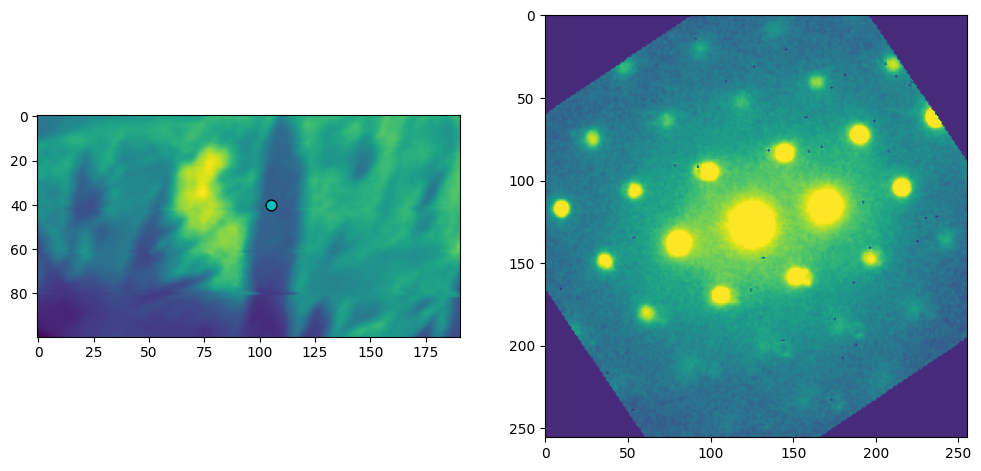

In [53]:
# xind, yind = 33,9
xind, yind = 40,105
#xind, yind = 70,150


k_max = 1.4
sigma_compare = 0.02
range_plot = np.array([k_max,k_max])

colors = ['r']

#Show where the diffraction pattern comes from
fig,ax = plt.subplots(1,2,figsize=(12,6))
ax[0].imshow(dataset.tree['dark_field'].data)
ax[0].scatter(yind,xind, fc='c', ec='k', s=60)
ax[1].imshow(ndi.rotate(dataset.data[xind,yind,:,:]**0.33,angle, reshape=False, cval=1.), 
             vmax=8
             , cmap='viridis')


In [54]:
bragg_peaks.calibration

Calibration( A Metadata instance called 'calibration', containing the following fields:

             Q_pixel_size:          0.009585381600738786
             R_pixel_size:          3.0
             Q_pixel_units:         A^-1
             R_pixel_units:         nm
             qx0_meas:              2D-array
             qy0_meas:              2D-array
             qx0:                   2D-array
             qx0_mean:              125.50630289287909
             qx0_shift:             2D-array
             qy0:                   2D-array
             qy0_mean:              126.00352287342277
             qy0_shift:             2D-array
             QR_rotation_degrees:   0.5934517697793025
             QR_flip:               False
)

Best fit lattice directions: z axis = ([ 0.441 -0.191 -0.249  0.722]), x axis = ([ 0.61  -0.243 -0.366  0.18 ]), with corr value = 8.497
Best fit lattice directions: z axis = ([0.507 0.535 0.676]), x axis = ([0.301 0.634 0.713]), with corr value = 5.378


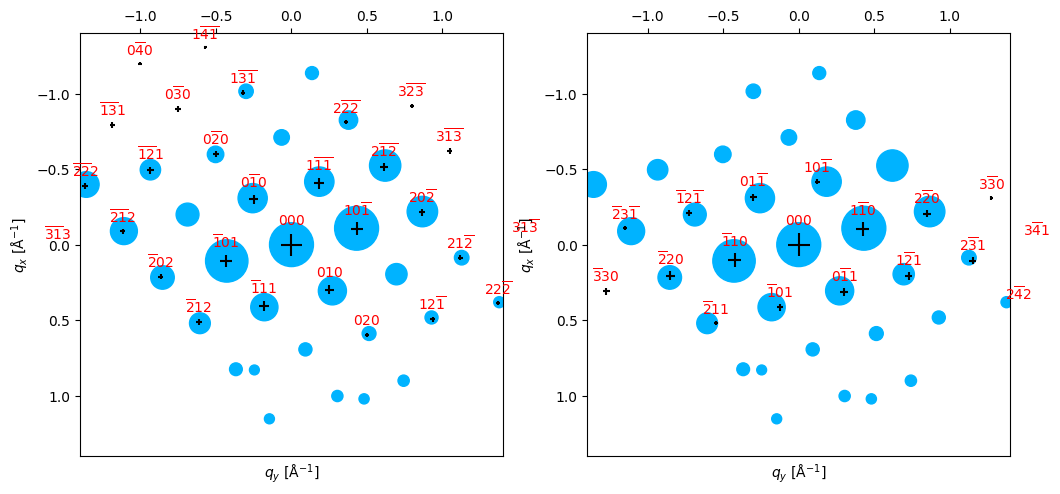

In [55]:
#Calculate orientations on single pattern as a test
orientation_alpha  = Ti_alpha.match_single_pattern(
    bragg_peaks.vectors[xind,yind],
    num_matches_return = 1,
    plot_corr=False,
    verbose=True,
)
orientation_beta  = Ti_beta.match_single_pattern(
    bragg_peaks.vectors[xind,yind],
    num_matches_return = 1,
    plot_corr=False,
    verbose=True,
)
#Generate diffraction patterns
bragg_peaks_fit_alpha_0 = Ti_alpha.generate_diffraction_pattern(
    orientation_alpha,
    ind_orientation=0,
    sigma_excitation_error=sigma_compare)
figsize = (6,6)
fig,ax = plt.subplots(1,2,figsize=(2*figsize[0],figsize[1]))
#Plot the matches
py4DSTEM.process.diffraction.plot_diffraction_pattern(
    bragg_peaks_fit_alpha_0,
    bragg_peaks_compare=bragg_peaks.vectors[xind,yind],
    scale_markers=500,
    scale_markers_compare=25,
    plot_range_kx_ky=range_plot,
    min_marker_size=1,
    figsize=figsize,
    input_fig_handle=(fig,[ax[0]])
)

#Generate diffraction patterns
bragg_peaks_fit_beta_0 = Ti_beta.generate_diffraction_pattern(
    orientation_beta,
    ind_orientation=0,
    sigma_excitation_error=sigma_compare)
#Plot the matches
py4DSTEM.process.diffraction.plot_diffraction_pattern(
    bragg_peaks_fit_beta_0,
    bragg_peaks_compare=bragg_peaks.vectors[xind,yind],
    scale_markers=500,
    scale_markers_compare=25,
    plot_range_kx_ky=range_plot,
    min_marker_size=1,
    figsize=figsize,
    input_fig_handle=(fig,[ax[1]])
)


In [56]:
rcup = {
    'font.size':18,
}
plt.rcParams.update(rcup)

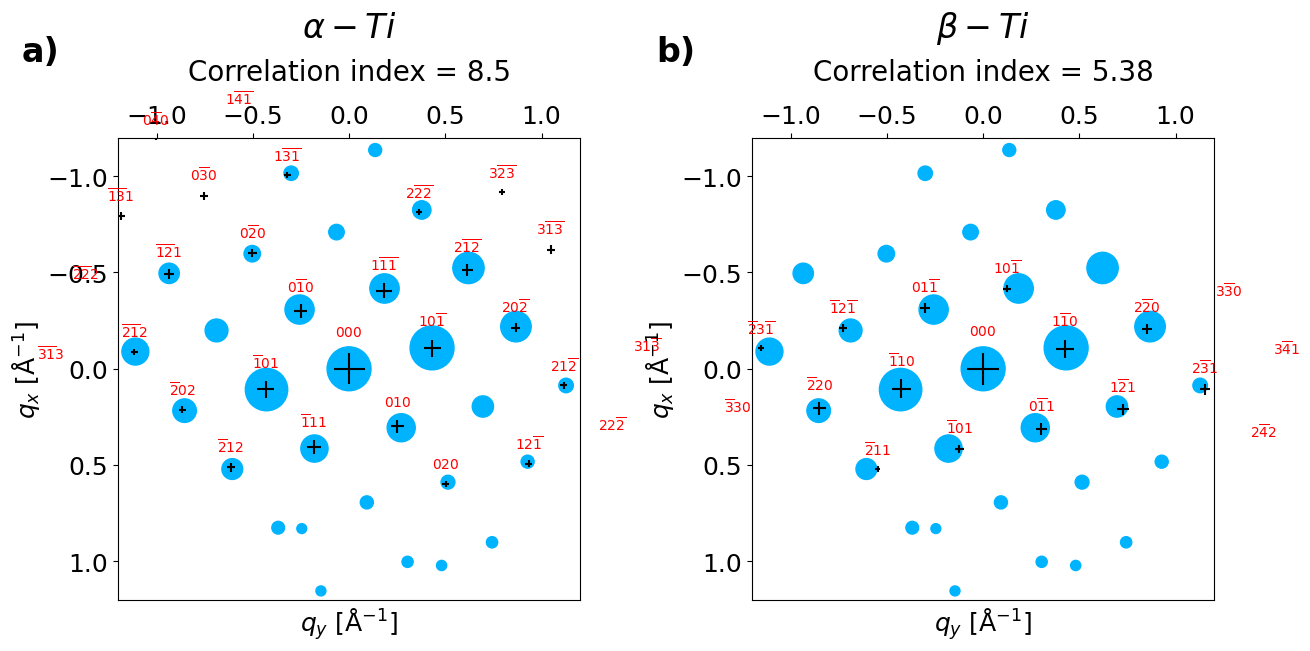

In [57]:
figsize = (7.5,6)
fig,ax = plt.subplots(1,2,figsize=(2*figsize[0],figsize[1]))

k_max = 1.2
sigma_compare = 0.02
range_plot = np.array([k_max,k_max])


py4DSTEM.process.diffraction.plot_diffraction_pattern(
    bragg_peaks_fit_alpha_0,
    bragg_peaks_compare=bragg_peaks.vectors[xind,yind],
    scale_markers=1000,
    scale_markers_compare=25,
    plot_range_kx_ky=range_plot,
    min_marker_size=1,
    figsize=figsize,
    input_fig_handle=(fig,[ax[0]])
)
ax[0].set_title(r'$\alpha-Ti$', y=1.2, size=24)
ax[0].text(0, -1.5, 'Correlation index = '+str(round(orientation_alpha.corr[0],2)),
          horizontalalignment='center', size=20)
ax[0].text(-1.7,-1.6, 'a)', size=24, fontweight='bold')

py4DSTEM.process.diffraction.plot_diffraction_pattern(
    bragg_peaks_fit_beta_0,
    bragg_peaks_compare=bragg_peaks.vectors[xind,yind],
    scale_markers=1000,
    scale_markers_compare=25,
    plot_range_kx_ky=range_plot,
    min_marker_size=1,
    figsize=figsize,
    input_fig_handle=(fig,[ax[1]])
)
ax[1].set_title(r'$\beta-Ti$', y=1.2, size=24)
ax[1].text(0, -1.5, 'Correlation index = '+str(round(orientation_beta.corr[0],2)),
          horizontalalignment='center', size=20)
ax[1].text(-1.7,-1.6, 'b)', size=24, fontweight='bold')

fig.savefig(filepath+'Figure2.png', bbox_inches='tight')

In [58]:
# Fit orientation to all probe positions
orientation_map_alpha = Ti_alpha.match_orientations(
    bragg_peaks.vectors,
    num_matches_return = 1,
    min_number_peaks=3
)

Matching Orientations: 100%|██████████| 19100/19100 [52:22<00:00,  6.08 PointList/s]


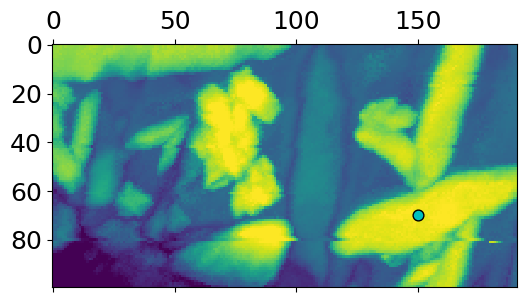

In [59]:
fig, ax = py4DSTEM.visualize.show(orientation_map_alpha.corr, cmap='viridis',figsize=(6,6), returnfig=True)
ax.scatter(x,y, fc='c', ec='k', s=60)

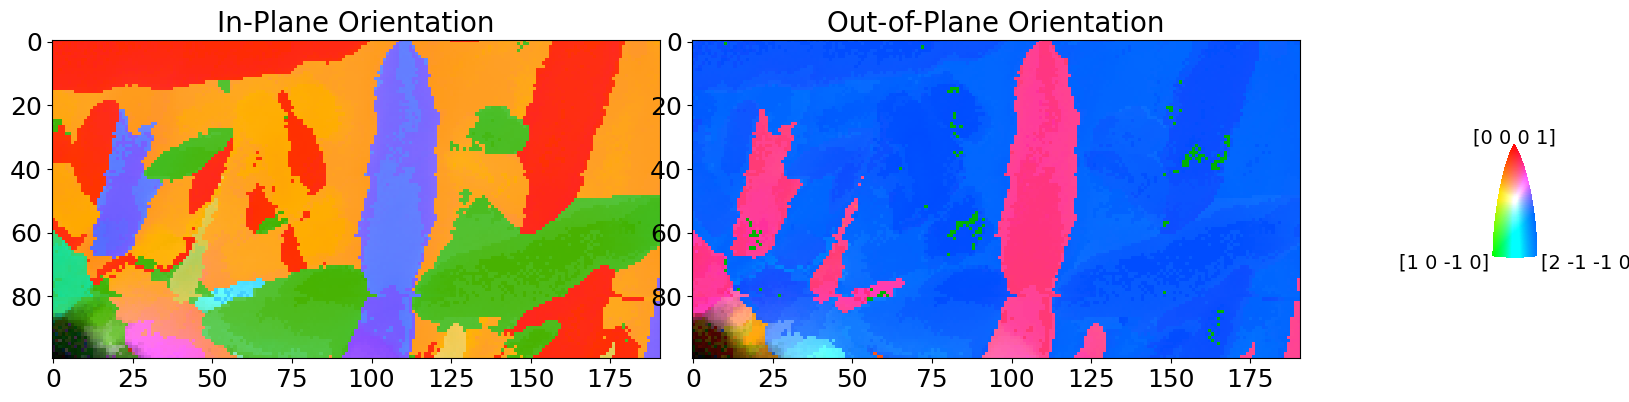

In [60]:
# plot orientation map alpha
images_orientation = Ti_alpha.plot_orientation_maps(
    orientation_map_alpha,
    corr_range=np.array([0.03,5]),
    corr_normalize=False,
    camera_dist = 12,
)

In [61]:
#Saves a .ang file
basename = 'Ti550_scan5_13_10_norot3'
alphatag = '_alpha'

Ti_alpha.save_ang_file(
    filepath+basename+alphatag+'.ang',
    orientation_map_alpha,
    pixel_size=step,
    pixel_units='nm',
    transpose_xy=False
)

In [62]:
# Fit orientation to all probe positions
orientation_map_beta = Ti_beta.match_orientations(
    bragg_peaks.vectors,
    num_matches_return = 1,
    min_number_peaks=3
)

Matching Orientations: 100%|██████████| 19100/19100 [10:27<00:00, 30.42 PointList/s]


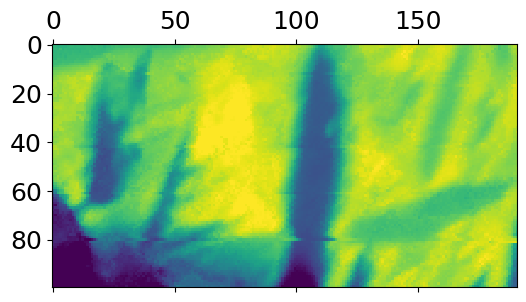

In [63]:
py4DSTEM.visualize.show(orientation_map_beta.corr, cmap='viridis',figsize=(6,6))


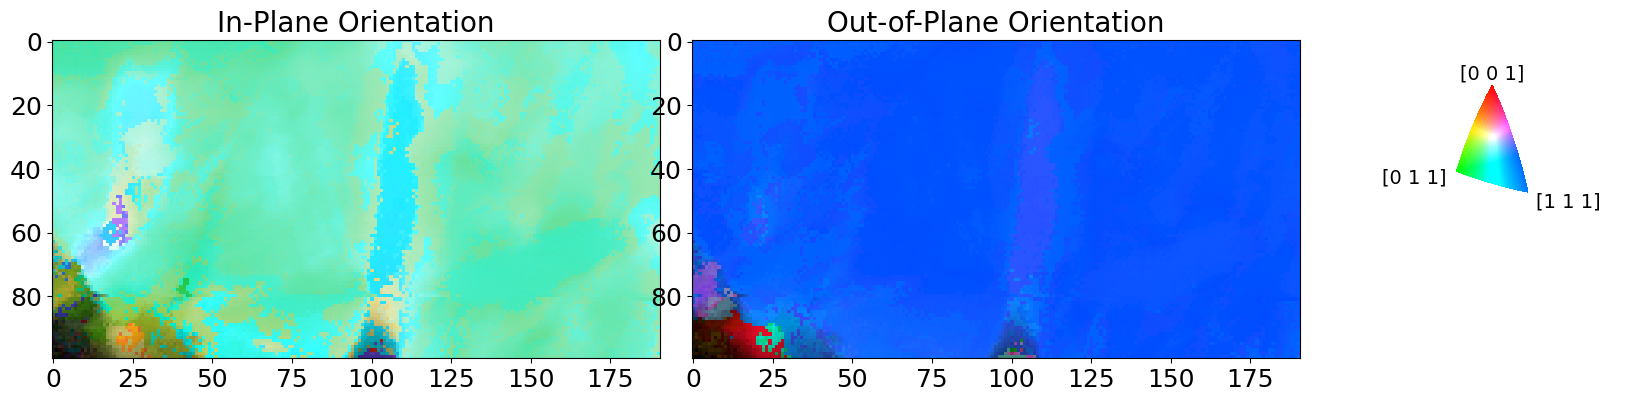

In [64]:
# plot orientation map beta
images_orientation = Ti_beta.plot_orientation_maps(
    orientation_map_beta,
    corr_range=np.array([0.03,5]),
    corr_normalize=False,
    camera_dist = 12,
)

In [65]:
#Saves a .ang file
betatag = '_beta'

Ti_beta.save_ang_file(
    filepath+basename+betatag+'.ang',                        
    orientation_map_beta, 
    pixel_size=step, 
    pixel_units='nm',
    transpose_xy=False
)